# Titanic Data Analysis
## Goal of Analysis: Use machine learning algorithms to get best accuracy of predictions for who survived the sinking of the Titanic given the attributes in the dataset. 

In [5]:
#Imports 
import pandas as pd
import numpy as np
import pandas_profiling
from sklearn.model_selection import train_test_split 
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import random
import matplotlib.pyplot as plt
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from sklearn import preprocessing
from io import StringIO
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from numpy.random import seed

# Data Analysis

In [6]:
titanic_df = pd.read_csv("titanic_data.csv")
titanic_df

Pclass                                             Name  Gender   Age  \
0          1                    Allen, Miss. Elisabeth Walton  female  29.0   
1          1                   Allison, Master. Hudson Trevor    male   1.0   
2          1                     Allison, Miss. Helen Loraine  female   2.0   
3          1             Allison, Mr. Hudson Joshua Creighton    male  30.0   
4          1  Allison, Mrs. Hudson J C (Bessie Waldo Daniels)  female  25.0   
...      ...                                              ...     ...   ...   
1304       3                             Zabour, Miss. Hileni  female  15.0   
1305       3                            Zabour, Miss. Thamine  female   NaN   
1306       3                        Zakarian, Mr. Mapriededer    male  27.0   
1307       3                              Zakarian, Mr. Ortin    male  27.0   
1308       3                               Zimmerman, Mr. Leo    male  29.0   

      SibSp  Parch  Ticket    Fare    Cabin Embarked  Survived  
0         0      0   24160  211.34       B5        S         1  
1         1      2  113781  151.55  C22 C26        S         1  
2         1      2  113781  151.55  C22 C26        S         0  
3         1      2  113781  151.55  C22 C26        S         0  
4         1      2  113781  151.55  C22 C26        S         0  
...     ...    ...     ...     ...      ...      ...       ...  
1304      1      0    2665   14.45      NaN        C         0  
1305      1      0    2665   14.45      NaN        C         0  
1306      0      0    2656    7.23      NaN        C         0  
1307      0      0    2670    7.23      NaN        C         0  
1308      0      0  315082    7.88      NaN        S         0  

[1309 rows x 11 columns]

## Data Exploration

In [7]:
titanic_df.describe()

Pclass          Age        SibSp        Parch         Fare  \
count  1309.000000  1046.000000  1309.000000  1309.000000  1308.000000   
mean      2.294882    29.897706     0.498854     0.385027    33.296261   
std       0.837836    14.414973     1.041658     0.865560    51.758691   
min       1.000000     0.000000     0.000000     0.000000     0.000000   
25%       2.000000    21.000000     0.000000     0.000000     7.900000   
50%       3.000000    28.000000     0.000000     0.000000    14.450000   
75%       3.000000    39.000000     1.000000     0.000000    31.280000   
max       3.000000    80.000000     8.000000     9.000000   512.330000   

          Survived  
count  1309.000000  
mean      0.381971  
std       0.486055  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       1.000000  
max       1.000000

In [8]:
# Search for overall trends in the dataset
pandas_profiling.ProfileReport(titanic_df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Data Cleaning

In [9]:
#Age is skewed and has a significant number of missing values so best to replace missing values with median of data
age_median = titanic_df['Age'].median(skipna=True)
titanic_df['Age'].fillna(age_median, inplace=True)

In [10]:
#Cabin has too many missing values and will be completely dropped from the dataframe
titanic_df.drop('Cabin', axis=1, inplace=True)

In [11]:
#Embarked only has 2 missing values and can be replaced with the most common which is S
titanic_df['Embarked'].fillna("S", inplace=True)

In [12]:
#Fare has one missing value and can be replaced with the median because it is highly skewed
fare_median = titanic_df['Fare'].median(skipna=True)
titanic_df['Fare'].fillna(fare_median,inplace=True)

## Feature Engineering

In [13]:
#SibSp - Number of siblings/spouses aboard
#Parch - Number of parents/children aboard
#These two variables overlap for every passenger that has this data so I am creating a variable that just detects 
#whether someone is traveling alone or not to account for multicollinearity
titanic_df['TravelGroup']=titanic_df["SibSp"]+titanic_df["Parch"]
titanic_df['TravelAlone']=np.where(titanic_df['TravelGroup']>0, 0, 1) 
titanic_df.head()

Pclass                                             Name  Gender   Age  \
0       1                    Allen, Miss. Elisabeth Walton  female  29.0   
1       1                   Allison, Master. Hudson Trevor    male   1.0   
2       1                     Allison, Miss. Helen Loraine  female   2.0   
3       1             Allison, Mr. Hudson Joshua Creighton    male  30.0   
4       1  Allison, Mrs. Hudson J C (Bessie Waldo Daniels)  female  25.0   

   SibSp  Parch  Ticket    Fare Embarked  Survived  TravelGroup  TravelAlone  
0      0      0   24160  211.34        S         1            0            1  
1      1      2  113781  151.55        S         1            3            0  
2      1      2  113781  151.55        S         0            3            0  
3      1      2  113781  151.55        S         0            3            0  
4      1      2  113781  151.55        S         0            3            0

In [14]:
#Does total size of group change the probability of surviving? 
#Initial thought: People who want to check up on the safety of more people take more time looking for them 
#and die as a result of not trying to escape
titanic_df['TravelTotal'] = titanic_df['TravelGroup'] + 1

In [15]:
#Drop unnecessary variables   - thanks for the help Jeffrey!
titanic_df.drop('SibSp', axis=1, inplace=True)
titanic_df.drop('Parch', axis=1, inplace=True)
titanic_df.drop('TravelGroup', axis=1, inplace=True)
titanic_df.drop('Ticket', axis=1, inplace=True)
titanic_df.drop('Name', axis=1, inplace=True)

In [16]:
#Hot Encode PClass, Gender, Embarked
le = preprocessing.LabelEncoder()
pclass_cat = le.fit_transform(titanic_df.Pclass)
gender_cat = le.fit_transform(titanic_df.Gender)
embarked_cat = le.fit_transform(titanic_df.Embarked)

#Initialize the encoded categorical columns
titanic_df['pclass_cat'] = pclass_cat
titanic_df['gender_cat'] = gender_cat
titanic_df['embarked_cat'] = embarked_cat

#Drop old categorical fields from dataframe and reindex
dummy_fields = ['Pclass','Gender','Embarked']
data = titanic_df.drop(dummy_fields, axis = 1)
data = titanic_df.reindex(['pclass_cat','gender_cat','Age','Fare','embarked_cat','TravelAlone', 'TravelTotal','Survived'],axis=1)

In [17]:
data

pclass_cat  gender_cat   Age    Fare  embarked_cat  TravelAlone  \
0              0           0  29.0  211.34             2            1   
1              0           1   1.0  151.55             2            0   
2              0           0   2.0  151.55             2            0   
3              0           1  30.0  151.55             2            0   
4              0           0  25.0  151.55             2            0   
...          ...         ...   ...     ...           ...          ...   
1304           2           0  15.0   14.45             0            0   
1305           2           0  28.0   14.45             0            0   
1306           2           1  27.0    7.23             0            1   
1307           2           1  27.0    7.23             0            1   
1308           2           1  29.0    7.88             2            1   

      TravelTotal  Survived  
0               1         1  
1               4         1  
2               4         0  
3               4         0  
4               4         0  
...           ...       ...  
1304            2         0  
1305            2         0  
1306            1         0  
1307            1         0  
1308            1         0  

[1309 rows x 8 columns]

In [18]:
#Normalize the continuous variables
continuous = ['Age', 'Fare', 'TravelTotal']

scaler = StandardScaler()

for var in continuous:
    data[var] = data[var].astype('float64')
    data[var] = scaler.fit_transform(data[var].values.reshape(-1, 1))

In [19]:
data

pclass_cat  gender_cat       Age      Fare  embarked_cat  TravelAlone  \
0              0           0 -0.040027  3.442616             2            1   
1              0           1 -2.210230  2.286623             2            0   
2              0           0 -2.132722  2.286623             2            0   
3              0           1  0.037481  2.286623             2            0   
4              0           0 -0.350056  2.286623             2            0   
...          ...         ...       ...       ...           ...          ...   
1304           2           0 -1.125128 -0.364099             0            0   
1305           2           0 -0.117534 -0.364099             0            0   
1306           2           1 -0.195041 -0.503693             0            1   
1307           2           1 -0.195041 -0.503693             0            1   
1308           2           1 -0.040027 -0.491125             2            1   

      TravelTotal  Survived  
0       -0.558346         1  
1        1.336749         1  
2        1.336749         0  
3        1.336749         0  
4        1.336749         0  
...           ...       ...  
1304     0.073352         0  
1305     0.073352         0  
1306    -0.558346         0  
1307    -0.558346         0  
1308    -0.558346         0  

[1309 rows x 8 columns]

In [20]:
#Make sure data is clean/check for null
data[data.isnull().any(axis=1)].head()

Empty DataFrame
Columns: [pclass_cat, gender_cat, Age, Fare, embarked_cat, TravelAlone, TravelTotal, Survived]
Index: []

## Models

### Test Train Split

In [21]:
#Split inputs and output
X = data.iloc[:, 0:7] 
Y = data.iloc[:, 7]

In [22]:
#Test/Train Split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

### Naive Bayes Classifier

In [23]:
#NB - All columns
#Initialize + fit model
gnb = GaussianNB().fit(X_train, y_train)

#Predictions
y_pred = gnb.predict(X_test)

#Accuracy Score
NB_all_accuracy = accuracy_score(y_test,y_pred)
print('Naive Bayes Model Accuracy with all attributes: {0:.2f}'.format(NB_all_accuracy))

Naive Bayes Model Accuracy with all attributes: 0.83


### Decision Tree 

In [24]:
#DT1 - All attributes
#Initalize + fit model
tree = DecisionTreeClassifier(criterion = 'entropy', min_samples_split = 2, random_state=5).fit(X_train, y_train)

#Predictions
y_pred = tree.predict(X_test)

#Accuracy Score
tree_all_accuracy = accuracy_score(y_test, y_pred)
print('Decision Tree Accuracy with all attributes: {0:.2f}'.format(tree_all_accuracy))

Decision Tree Accuracy with all attributes: 0.81


In [25]:
#Tree visualization function
def visualize_tree(tree_data, names):
    dot_data = StringIO()
    export_graphviz(tree_data,out_file=dot_data,
                         feature_names=names,
                         filled=True,rounded=True, 
                         special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return Image(graph.create_png())


(process:36760): GLib-GIO-WARNING **: 12:35:48.619: Unexpectedly, UWP app `Clipchamp.Clipchamp_2.4.9.0_neutral__yxz26nhyzhsrt' (AUMId `Clipchamp.Clipchamp_yxz26nhyzhsrt!App') supports 41 extensions but has no verbs



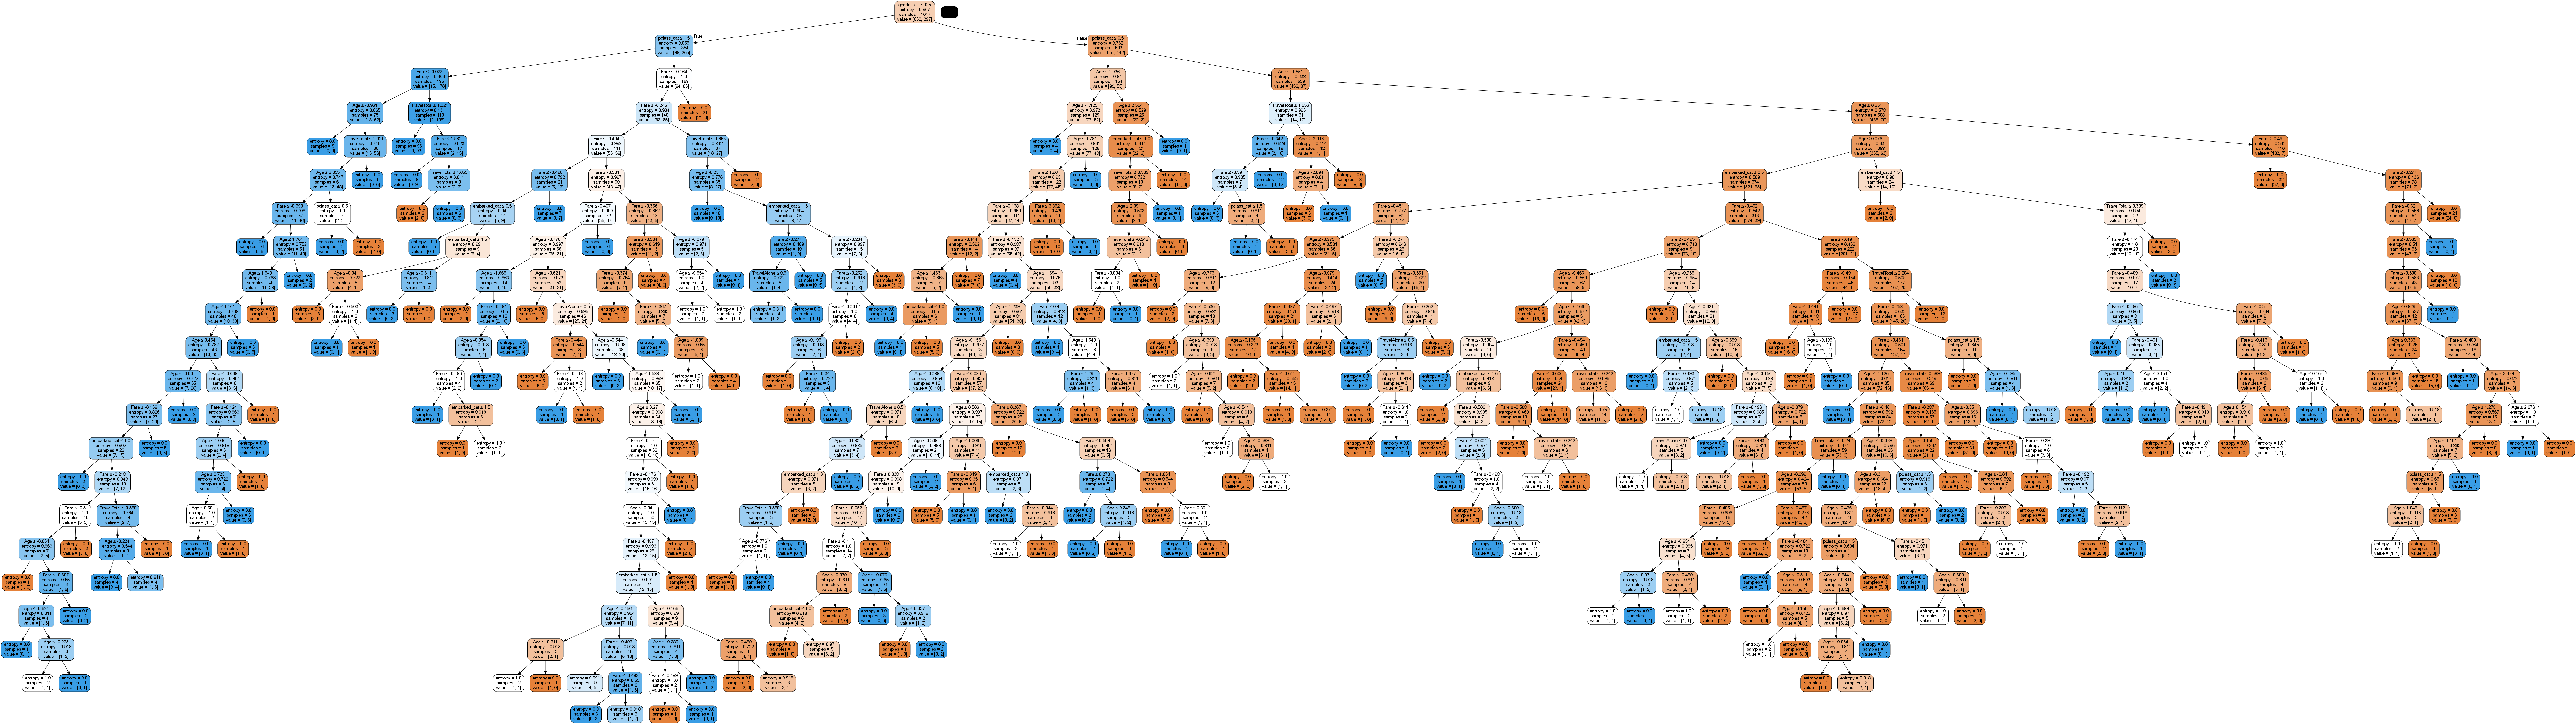

In [26]:
#DT1 Graph
names = ['pclass_cat','gender_cat','Age','Fare','embarked_cat','TravelAlone','TravelTotal']
visualize_tree(tree,names)

In [27]:
print(tree.feature_importances_)

[0.10584503 0.21408169 0.25546532 0.32374788 0.03381971 0.01055945
 0.05648093]


In [28]:
high_importance = ['gender_cat','Age','Fare']
X_train2 = X_train[high_importance]
X_test2 = X_test[high_importance]

In [29]:
#DT2 - Top 3 features only
#Initialize + fit model
tree2 = DecisionTreeClassifier(criterion = 'gini', min_samples_split = 2, random_state=5).fit(X_train2, y_train)

#Predictions 
y_pred2 = tree2.predict(X_test2)

#Accuracy Score
tree_imp_accuracy = accuracy_score(y_test, y_pred2)
print('Decision Tree Accuracy with high importance attributes: {0:.2f}'.format(tree_imp_accuracy))

Decision Tree Accuracy with high importance attributes: 0.77



(process:42160): GLib-GIO-WARNING **: 12:35:55.768: Unexpectedly, UWP app `Clipchamp.Clipchamp_2.4.9.0_neutral__yxz26nhyzhsrt' (AUMId `Clipchamp.Clipchamp_yxz26nhyzhsrt!App') supports 41 extensions but has no verbs



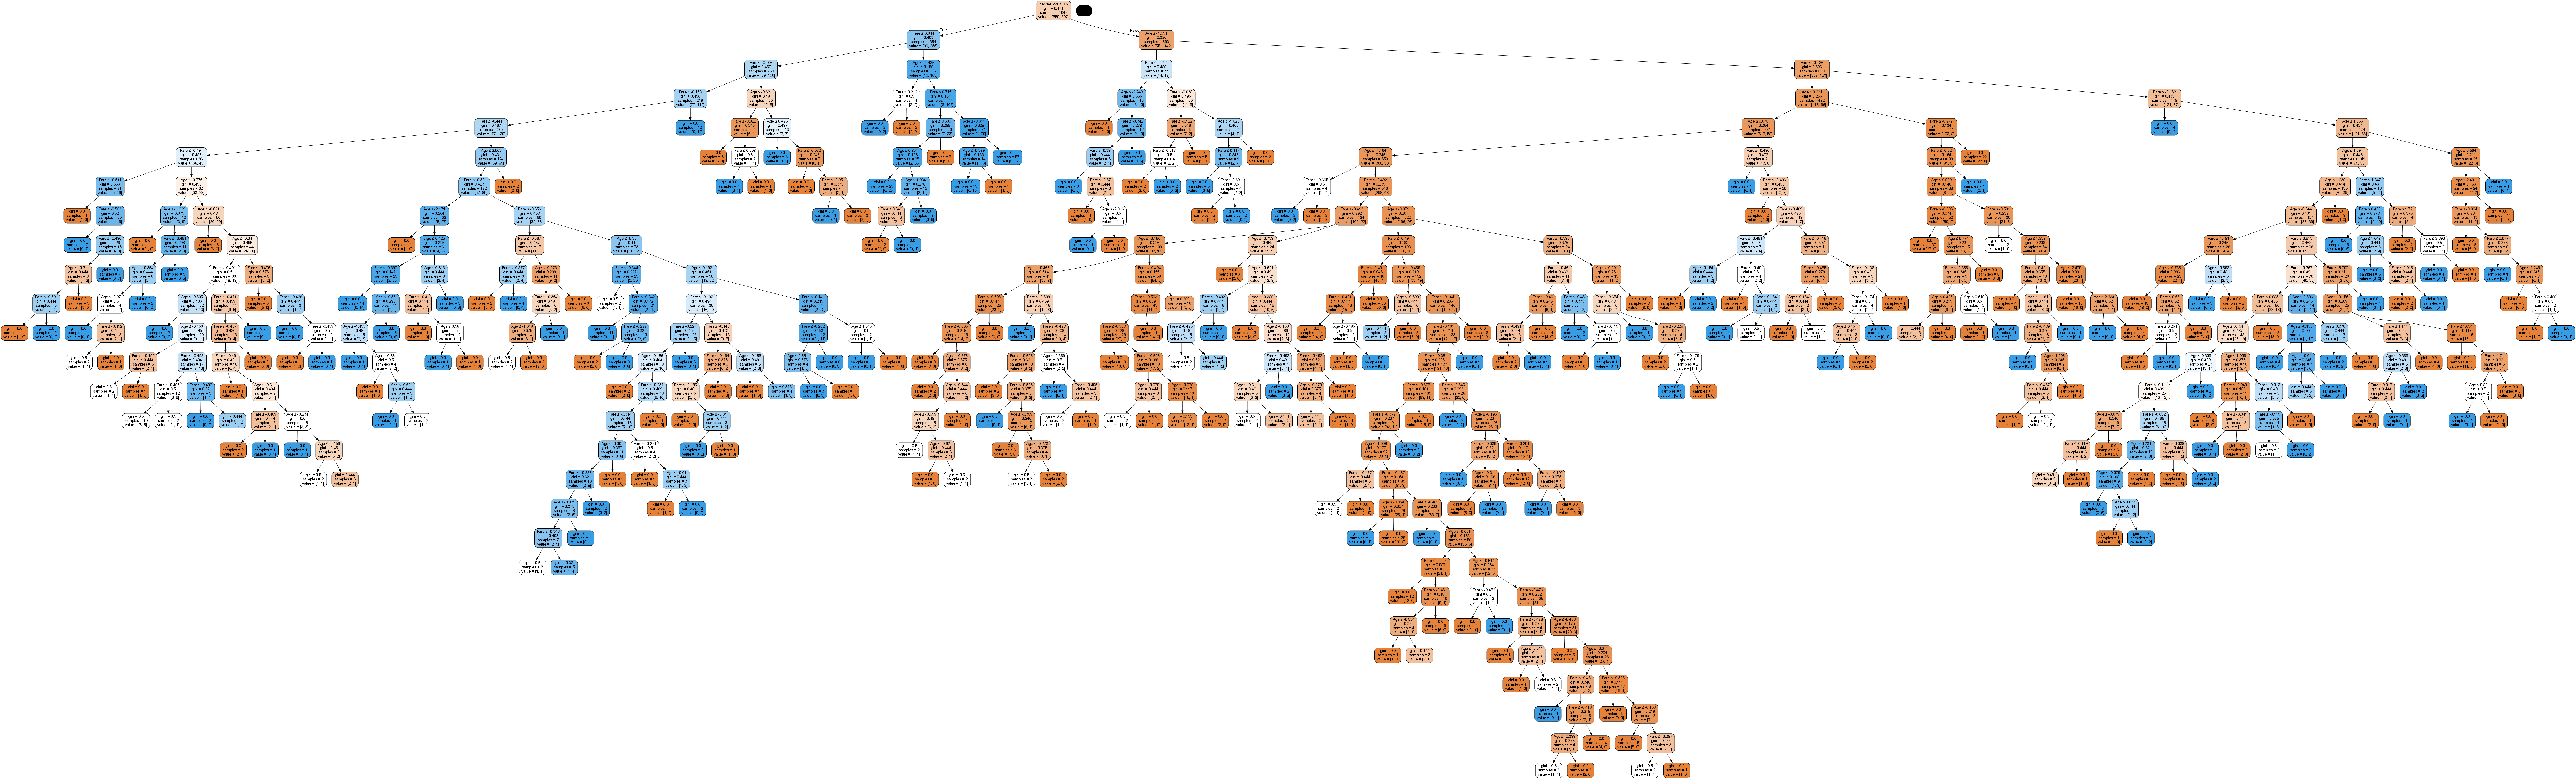

In [30]:
#DT2 Graph
visualize_tree(tree2,high_importance)

### Random Forest

In [31]:
#RF1 - All attributes
#Initalize + fit model
clf = RandomForestClassifier(n_jobs=2, random_state=0).fit(X_train, y_train)

#Predictions
y_pred = clf.predict(X_test)

#Accuracy Score
RF_all_accuracy = accuracy_score(y_test,y_pred)
print('Random Forest Accuracy with all attributes: {0:.2f}'.format(RF_all_accuracy))

Random Forest Accuracy with all attributes: 0.83


In [32]:
print(clf.feature_importances_)

[0.07132924 0.24135446 0.2736879  0.30554065 0.03122174 0.01307411
 0.06379191]


In [33]:
#RF2 - Top 3 features only
#Initialize + fit model
clf2 = RandomForestClassifier(n_jobs=2, random_state=0).fit(X_train2, y_train)

#Predictions
y_pred2 = clf2.predict(X_test2)

#Accuracy Score
RF_imp_accuracy = accuracy_score(y_test,y_pred2)
print('Random Forest Accuracy with high importance attributes: {0:.2f}'.format(RF_imp_accuracy))

Random Forest Accuracy with high importance attributes: 0.79


## Compare Accuracy Scores


In [34]:
#All Accuracies
print('NB accuracy: {0:.2f}'.format(NB_all_accuracy))

print("Decision Tree:")
print('All attributes: {0:.2f}'.format(tree_all_accuracy))
print('High importance attributes: {0:.2f}'.format(tree_imp_accuracy))

print("Random Forest:")
print('All attributes: {0:.2f}'.format(RF_all_accuracy))
print('High importance attributes: {0:.2f}'.format(RF_imp_accuracy))

NB accuracy: 0.83
Decision Tree:
All attributes: 0.81
High importance attributes: 0.77
Random Forest:
All attributes: 0.83
High importance attributes: 0.79
